In [16]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import random
import torch.nn as nn
from typing import Callable, Iterable
from dataclasses import dataclass
from torchvision.transforms import ToTensor
import torch.optim.sgd
import torch
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
import torchvision.transforms as T

import sys
sys.path.append('/content/drive/MyDrive/Colab_project/image_segmentataion')

import modules.dataset as dataset
import modules.configration as configration
import importlib
import modules.DeepLabV3Plus as DeepLabV3Plus
import modules.evaluation as evaluation
import modules.Trainer as Trainer

In [17]:
dataset_confing = configration.DatasetConfig(
    train_datapath = 'DATASETS/',
    train_images_folder = 'imgs/imgs/',
    train_masks_folder = 'masks/masks/',
    train_csv_path = 'DATASETS/',
    train_csv_name = 'train.csv',
    test_csv_path = 'DATASETS/',
    test_csv_name = 'test.csv',
    test_images_folder='imgs/imgs/',
    test_masks_folder='masks/masks/'
)

In [18]:
importlib.reload(Trainer)
importlib.reload(evaluation)

def main():
    torch.cuda.empty_cache()
    seg_model = DeepLabV3Plus.DeepLabV3Plus(num_classes=12, rate=[1,2,4,6])
    seg_model = seg_model.to("cuda")
    loss_fn = evaluation.focal_loss(class_num=12, mode="mean")
    dice_coef = evaluation.dice_coeffienet_metric(num_class=12)

    #Configuration of model training
    optim_config = configration.OptimizerConfig(
        learning_rate=0.1,
        momentum=0.9,
        weight_decay=0.0001,
        lr_step_size=1,
        lr_gamma=0.9)

    roots_path = ''


    dataset_confing = configration.DatasetConfig(
        train_datapath = roots_path +'DATASETS/',
        train_images_folder =  'imgs/imgs/',
        train_masks_folder =  'masks/masks/',
        train_csv_path = roots_path + 'DATASETS/',
        train_csv_name =  'train.csv',
        test_csv_path = roots_path + 'DATASETS/',
        test_csv_name = 'test.csv',
        test_images_folder='imgs/imgs/',
        test_masks_folder= 'masks/masks/'
    )

    dataloader_config = configration.DataloaderConfig(batch_size=8,num_workers=4)

    augmentation = transforms.RandomApply(
        [transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.05, hue=0.05)],
        p=0.3
    )
    #Define Dataset and Dataloader
    train_dataset = dataset.SemSegDataset(data_path=dataset_confing.train_datapath,
                                images_folder=dataset_confing.train_images_folder,
                                masks_folder=dataset_confing.train_masks_folder,
                                csv_path=dataset_confing.train_csv_path,
                                csv_name=dataset_confing.train_csv_name,
                                augmentation = augmentation,
                                img_size=(513, 513))

    set_size = len(train_dataset)
    train_dataset_size = int(set_size * 0.8)
    valid_dataset_size = set_size - train_dataset_size

    train_indces, valid_indces = torch.utils.data.random_split(range(set_size), [train_dataset_size, valid_dataset_size])

    valid_datset = dataset.SemSegDataset(data_path=dataset_confing.train_datapath,
                                images_folder=dataset_confing.train_images_folder,
                                masks_folder=dataset_confing.train_masks_folder,
                                csv_path=dataset_confing.train_csv_path,
                                csv_name=dataset_confing.train_csv_name,
                                augmentation = None,
                                img_size=(513, 513),
                                train_state = False)
    
    train_dataset = torch.utils.data.Subset(train_dataset, train_indces)
    valid_dataset = torch.utils.data.Subset(valid_datset, valid_indces)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=dataloader_config.batch_size, num_workers=dataloader_config.num_workers)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=dataloader_config.batch_size, num_workers=dataloader_config.num_workers)
    #Define optimizer
    optimizer = torch.optim.SGD(seg_model.parameters(),
                                lr = optim_config.learning_rate,
                                weight_decay=optim_config.weight_decay,
                                momentum=optim_config.momentum)

    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer, 
                                                              mode = 'min',
                                                              patience=2,
                                                              factor = 0.1,
                                                              verbose=True )

    #Main trainning Loop
    model_train = Trainer.Trainer(seg_model, train_dataloader, valid_dataloader, loss_fn, dice_coef, optimizer, lr_scheduler, device = "cuda")
    model_train.fit(100)

if __name__ == "__main__":
    main()

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:  0

[0/100][Train][0] Loss_avg: 4.5401, Loss: 4.5401, LR: 0.1
[0/100][Train][20] Loss_avg: 2.6487, Loss: 1.3106, LR: 0.1
[0/100][Train][40] Loss_avg: 2.1166, Loss: 1.9365, LR: 0.1


KeyboardInterrupt: 

In [ ]:
class_id_dict = {
    0: (0, 0, 0),
    1: (192, 128, 128),
    2: (0, 128, 0),
    3: (128, 128, 128),
    4: (128, 0, 0),
    5: (0, 0, 128),
    6: (192, 0, 128),
    7: (192, 0, 0),
    8: (192, 128, 0),
    9: (0, 64, 0),
    10: (128, 128, 0),
    11: (0, 128, 128)
}
id_to_class = {
    0: "Background",
    1: "Person",
    2: "Bike",
    3: "Car",
    4: "Drone",
    5: "Boat",
    6: "Animal",
    7: "Obstacle",
    8: "Construction",
    9: "Vegetation",
    10: "Road",
    11: "Sky"
}

def colorize_mask(mask, color_dict):
    # (H, W, 3) 형태의 컬러 마스크 생성
    color_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)

    # 한 번에 변환하는 방식으로 최적화
    for i, color in color_dict.items():
        color_mask[mask == i] = color  # 조건을 만족하는 모든 위치에 RGB 적용

    return color_mask

In [ ]:

class segmentation_image_show():
    def __init__(self, 
                 model:torch.nn.Module,
                 id_to_color:dict,
                 id_to_class_dict:dict,
                 ):
        self.model = model
        self.id_to_color = id_to_color
        self.id_to_class = id_to_class_dict

    def show(self,image):
        mask = self.eval_model(device="cuda", image=image)

        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(image)
        ax[0].axis('off')
        ax[0].set_title('Image')

        ax[1].imshow(self.colorize_mask(mask))
        ax[1].axis('off')
        ax[1].set_title('Mask')

        plt.show()

    def colorize_mask(self,mask:np.array)->np.array:
        # (H, W, 3) 형태의 컬러 마스크 생성
        color_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)

        # 한 번에 변환하는 방식으로 최적화
        for class_id, color in self.id_to_color.items():
            color_mask[mask == class_id] = color
        return color_mask

    def eval_model(self,
                    device:str,
                    image:Image)->torch.Tensor:
        #image preprocessing

        test_transform = T.Compose([
            T.Resize((513, 513)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    
        image = test_transform(image).unsqueeze(0).to(device)
        
        with torch.no_grad():
            self.model.eval()
            output = self.model(image)
            output = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

        return output

C:\Users\User\AppData\Local\Temp\ipykernel_20212\4184552875.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  seg_model.load_state_dict(torch.load(model_path))


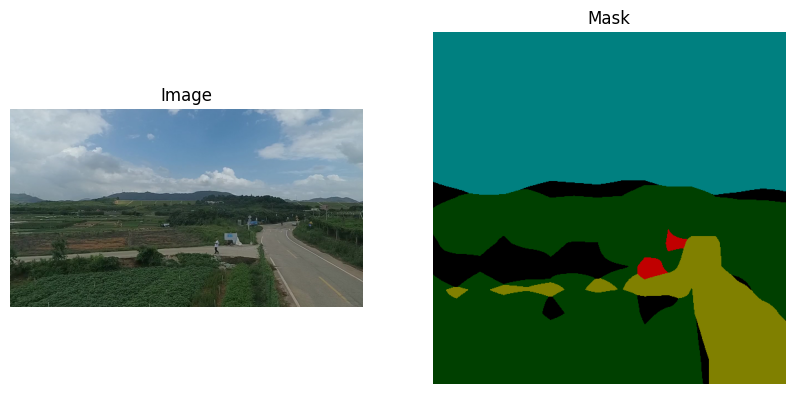

In [51]:
id_to_color = {
    0: (0, 0, 0),
    1: (192, 128, 128),
    2: (0, 128, 0),
    3: (128, 128, 128),
    4: (128, 0, 0),
    5: (0, 0, 128),
    6: (192, 0, 128),
    7: (192, 0, 0),
    8: (192, 128, 0),
    9: (0, 64, 0),
    10: (128, 128, 0),
    11: (0, 128, 128)
}
id_to_class = {
    0: "Background",
    1: "Person",
    2: "Bike",
    3: "Car",
    4: "Drone",
    5: "Boat",
    6: "Animal",
    7: "Obstacle",
    8: "Construction",
    9: "Vegetation",
    10: "Road",
    11: "Sky"
}

model_path = 'checkpoints\DeepLabV3Plus_best.pth'  # replace with the actual path to the saved model
seg_model = DeepLabV3Plus.DeepLabV3Plus(num_classes=12, rate=[1,2,4,6])
seg_model.load_state_dict(torch.load(model_path))
seg_model = seg_model.to("cuda")

image = Image.open('DATASETS/imgs/imgs/17627949849774160568.jpg')

segmodel_image_showing = segmentation_image_show(model = seg_model,
                                                 id_to_color = id_to_color,
                                                 id_to_class_dict=id_to_class)
result = segmodel_image_showing.eval_model( "cuda", image)

color_mask = segmodel_image_showing.colorize_mask(result)
segmodel_image_showing.show(image)
